In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import yaml
import torch
# from models_.lvmogp_svi import LVMOGP_SVI
from modules.prepare_and_train_model import LVMOGP_SVI 
from models_.gaussian_likelihood import GaussianLikelihood
from modules.prepare_data import *
from util_functions import *
from tqdm import trange

In [2]:
# Specify model and likelihood

with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/train_lvmogp_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
    n_outputs = config['n_outputs'],
    n_input = config['n_input_train'],
    input_dim = config['input_dim'],
    latent_dim = config['latent_dim'],
    n_inducing_input = config['n_inducing_input'],
    n_inducing_latent = config['n_inducing_latent'],
    data_Y = None,
    pca = config['pca'],
    learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
    learn_inducing_locations_input = config['learn_inducing_locations_input'],
    latent_kernel_type = config['latent_kernel_type'],
    input_kernel_type = config['input_kernel_type']
)

my_likelihood = GaussianLikelihood()

In [3]:
# Load trained model and likelihood

model_state_dict = torch.load(config['model_path'])
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(config['likelihood_path'])
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

# Load in dataset

In [4]:
if config['dataset_type'] == 'synthetic_regression':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls = prepare_synthetic_regression_data(config)

# Prediction function

In [5]:
from linear_operator.operators import CholLinearOperator, KroneckerProductLinearOperator
from linear_operator.operators import (
    LinearOperator,
    TriangularLinearOperator,
)
from gpytorch.settings import _linalg_dtype_cholesky

def _cholesky_factor(induc_induc_covar: LinearOperator) -> TriangularLinearOperator:
    L = psd_safe_cholesky(to_dense(induc_induc_covar).type(_linalg_dtype_cholesky.value()), max_tries=4)
    return TriangularLinearOperator(L)

K_uu_latent = my_model.covar_module_latent(my_model.variational_strategy.inducing_points_latent.data).to_dense().to(torch.float64)
K_uu_latent_inv = torch.linalg.solve(K_uu_latent, torch.eye(K_uu_latent.size(-1)).to(torch.float64))
K_uu_input = my_model.covar_module_input(my_model.variational_strategy.inducing_points_input.data).to_dense().to(torch.float64)
K_uu_input_inv = torch.linalg.solve(K_uu_input, torch.eye(K_uu_input.size(-1)).to(torch.float64))

K_uu = KroneckerProductLinearOperator(K_uu_latent, K_uu_input).to_dense().data
# chol_K_uu_inv_t = _cholesky_factor_latent(KroneckerProductLinearOperator(K_uu_latent_inv, K_uu_input_inv)).to_dense().data.t()
chol_K_uu_inv_t = KroneckerProductLinearOperator(
        torch.linalg.solve( _cholesky_factor(K_uu_latent).to_dense().data, torch.eye(K_uu_latent.size(-1)).to(torch.float64)),
        torch.linalg.solve( _cholesky_factor(K_uu_input).to_dense().data, torch.eye(K_uu_input.size(-1)).to(torch.float64)),
    ).to_dense().data.t()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

chol_covar_latent_u = my_model.variational_strategy._variational_distribution.chol_variational_covar_latent.data.to(torch.float64)
covar_latent_u = CholLinearOperator(chol_covar_latent_u).to_dense()
chol_covar_input_u = my_model.variational_strategy._variational_distribution.chol_variational_covar_input.data.to(torch.float64)
covar_input_u = CholLinearOperator(chol_covar_input_u).to_dense()

covar_u = KroneckerProductLinearOperator(covar_latent_u, covar_input_u).to_dense().data

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

common_background_information = {
                    'K_uu': K_uu.data,
                    'chol_K_uu_inv_t': chol_K_uu_inv_t.data, 
                    'm_u': my_model.variational_strategy._variational_distribution.variational_mean.data,
                    'Sigma_u': covar_u.data,
                    'A': chol_K_uu_inv_t @ (covar_u - torch.eye(covar_u.shape[0])) @ chol_K_uu_inv_t.t(),
                    'var_H': my_model.covar_module_latent.outputscale.data,
                    'var_X': my_model.covar_module_input.outputscale.data,
                    'W': my_model.covar_module_latent.base_kernel.lengthscale.data.reshape(-1)**2
                    }
'''
chol_K_uu_inv_t: inverse of K_uu matrix, of shape (M_H * M_X, M_H * M_X)
m_u: mean of the variational distribution
Sigma_u: covariance matrix of the variational distribution
A: chol_K_uu_inv_t (Sigma_u - K_uu) chol_K_uu_inv_t.T
var_H: 
var_X: 
W: vector; containing all lengthscales in the RAD kernel
c: constant
'''
c = (2 * torch.pi)**(config['latent_dim'] / 2) * common_background_information['var_H'] * common_background_information['W'].sqrt().prod()
common_background_information['constant_c'] = c

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

def integration_prediction_func(test_input, output_index, my_model, common_background_information=common_background_information):

    input_K_f_u = my_model.covar_module_input(test_input, my_model.variational_strategy.inducing_points_input.data).to_dense().data
    input_K_u_f_K_f_u = input_K_f_u.t() @ input_K_f_u

    data_specific_background_information = {
            'm_plus': my_model.X.q_mu.data[output_index],
            'Sigma_plus': 1.0 * my_model.X.q_log_sigma.exp().square().data[output_index],
            'input_K_f_u': input_K_f_u, 
            'input_K_u_f_K_f_u': input_K_u_f_K_f_u,
            'expectation_K_uu': None
    }
    
    # helper functions -----------------------------------------------------------------------------------------------------------------------
    def multivariate_gaussian_pdf(x, mu, cov):
        '''cov is a vector, representing all elements in the diagonal matrix'''
        k = mu.size(0)
        cov_det = cov.prod()
        cov_inv = torch.diag(1.0 / cov)
        norm_factor = torch.sqrt((2 * torch.pi) ** k * cov_det)

        x_mu = x - mu
        result = torch.exp(-0.5 * x_mu @ cov_inv @ x_mu.t()) / norm_factor
        return result.item()

    def G(h:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):

        mu = data_specific_background_information['m_plus']
        cov_diag = data_specific_background_information['Sigma_plus'] + common_background_information['W']
        result = multivariate_gaussian_pdf(h, mu, cov_diag)
        return common_background_information['constant_c'] * result

    def R(h_1:Tensor, h_2:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        mu_1 = h_2
        cov_diag_1 = 2 * common_background_information['W']
        mu_2 = (h_1 + h_2) / 2
        cov_diag_2 = 0.5 * common_background_information['W'] + data_specific_background_information['Sigma_plus']
        result1 = multivariate_gaussian_pdf(h_1, mu_1, cov_diag_1)
        result2 = multivariate_gaussian_pdf(data_specific_background_information['m_plus'], mu_2, cov_diag_2)
        return (common_background_information['constant_c'] ** 2 ) * result1 * result2
    
    def expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_f_u'].reshape(1, -1), data_specific_background_information['input_K_f_u'].reshape(1, -1)).to_dense().data 
        result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u'].to(result_.dtype)
        return result_
        
    def expectation_lambda_square(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = common_background_information['m_u']
        _result = result_ @ common_background_information['chol_K_uu_inv_t'].t().to(result_.dtype)
        interm_term = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data
        result_ = _result @ interm_term.to(result_.dtype) @ _result.t()
        # result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u']

        if data_specific_background_information['expectation_K_uu'] == None:
            data_specific_background_information['expectation_K_uu'] = interm_term
        return result_
        
    def expectation_gamma(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = common_background_information['var_H'] * common_background_information['var_X']

        if data_specific_background_information['expectation_K_uu'] == None:
            data_specific_background_information['expectation_K_uu'] = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], \
                                                                                                    data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data

        return result_ + (common_background_information['A'] * data_specific_background_information['expectation_K_uu']).sum()
    
    def integration_predictive_mean(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        return expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information)


    def integration_predictive_var(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        return expectation_lambda_square(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information) \
            + expectation_gamma(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information) \
            - expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information)**2
    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    expectation_latent_K_f_u = Tensor([G(my_model.variational_strategy.inducing_points_latent.data[i]).item() for i in range(config['n_inducing_latent'])])
    expectation_latent_K_u_f_K_f_u = Tensor([R(my_model.variational_strategy.inducing_points_latent.data[i], my_model.variational_strategy.inducing_points_latent.data[j]).item() \
                                            for j in range(config['n_inducing_latent']) for i in range(config['n_inducing_latent'])]).reshape(config['n_inducing_latent'], config['n_inducing_latent'])

    data_specific_background_information['expectation_latent_K_f_u'] = expectation_latent_K_f_u
    data_specific_background_information['expectation_latent_K_u_f_K_f_u'] = expectation_latent_K_u_f_K_f_u

    return integration_predictive_mean(data_specific_background_information=data_specific_background_information), \
           integration_predictive_var(data_specific_background_information=data_specific_background_information)



# Testing via integration

In [6]:
my_model.eval()
my_likelihood.eval()

all_index_latent = np.array([[i]*config['n_input'] for i in range(config['n_outputs'])]).reshape(-1).tolist() 
all_index_input = [i for i in range(config['n_input'])] * config['n_outputs'] 
len_outputs = len(all_index_latent)
assert len_outputs == len(all_index_input)

all_pred_mean = torch.zeros(len_outputs)
all_pred_var = torch.zeros(len_outputs)

# iteratively inference
for idx in trange(len_outputs, leave=True):
    curr_latent_index = all_index_latent[idx]
    curr_input = data_inputs[all_index_input[idx]].reshape(-1)
    curr_pred_mean, curr_pred_var = integration_prediction_func(test_input=curr_input,
                                                                output_index=curr_latent_index,
                                                                my_model=my_model,
                                                                common_background_information=common_background_information)
    all_pred_mean[idx] = curr_pred_mean
    all_pred_var[idx] = curr_pred_var + my_likelihood.noise.data
    

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [03:43<00:00, 22.39it/s]


In [146]:
# finer grid for better visualization ... nothing to do with RMSE computation ...
 
n_data4visual = 200
inputs_total4visual = Tensor(np.linspace(config['init_inducing_input_LB'], config['init_inducing_input_UB'], n_data4visual))
all_index_latent4visual = np.array([[i]*n_data4visual for i in range(config['n_outputs'])]).reshape(-1).tolist() 
all_index_input4visual = [i for i in range(n_data4visual)] * config['n_outputs'] 

len_outputs4visual = len(all_index_latent4visual)
assert len_outputs4visual == len(all_index_input4visual)

all_pred_mean4visual = torch.zeros(len_outputs4visual)
all_pred_var4visual = torch.zeros(len_outputs4visual)

# iteratively inference
for idx in trange(len_outputs4visual, leave=True):
    curr_latent_index4visual = all_index_latent4visual[idx]
    curr_input4visual = inputs_total4visual[all_index_input4visual[idx]].reshape(-1)
    curr_pred_mean4visual, curr_pred_var4visual = integration_prediction_func(test_input=curr_input4visual,
                                                                output_index=curr_latent_index4visual,
                                                                my_model=my_model,
                                                                common_background_information=common_background_information)
    all_pred_mean4visual[idx] = curr_pred_mean4visual
    all_pred_var4visual[idx] = curr_pred_var4visual + my_likelihood.noise.data
    

100%|██████████| 20000/20000 [14:58<00:00, 22.27it/s]


## Train/Test data RMSE

In [7]:
train_data_predict = all_pred_mean[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE', train_rmse)

w_test_data_predict = all_pred_mean[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE', test_rmse)

Global Train RMSE tensor(0.2783)
Global Test RMSE tensor(0.4168)


## Train/Test data NLL

In [8]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean[train_sample_idx_ls], GaussianVar=all_pred_var[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean[test_sample_idx_ls], GaussianVar=all_pred_var[test_sample_idx_ls])

print('Global Train negative log likelihood:', train_nll)
print('Global Test negative log likelihood:', test_nll)

Global Train negative log likelihood: tensor(0.0325)
Global Test negative log likelihood: tensor(0.4319)


## Visual Inspect

In [147]:
def evaluate_on_single_output(w_function_index):
    # Pick the index of the funtion to show
    # w_function_index = 982

    performance_dirct = {}
    w_train_input = data_inputs[ls_of_ls_train_input[w_function_index]]
    w_train_start = 0
    for i in range(w_function_index):
        w_train_start += len(ls_of_ls_train_input[i]) # don't assume every output has the same length of inputs
    w_train_end = w_train_start + len(ls_of_ls_train_input[w_function_index])
    w_train_target = data_Y_squeezed[train_sample_idx_ls][w_train_start:w_train_end]
    w_train_predict = train_data_predict[w_train_start:w_train_end]
    train_rmse_ = (w_train_target - w_train_predict).square().mean().sqrt()
    train_nll_ = neg_log_likelihood(w_train_target, all_pred_mean[train_sample_idx_ls][w_train_start:w_train_end], all_pred_var[train_sample_idx_ls][w_train_start:w_train_end])
    # print('train rmse', train_rmse_)
    # print('train nll:', train_nll_)
    performance_dirct['train_rmse'] = train_rmse_
    performance_dirct['train_nll'] = train_nll_

    w_test_input = data_inputs[ls_of_ls_test_input[w_function_index]]
    w_test_start = 0
    for j in range(w_function_index):
        w_test_start += len(ls_of_ls_test_input[i])
    w_test_end = w_test_start + len(ls_of_ls_test_input[w_function_index])
    w_test_target = data_Y_squeezed[test_sample_idx_ls][w_test_start:w_test_end]
    w_test_predict = w_test_data_predict[w_test_start:w_test_end]
    test_rmse_ = (w_test_predict - w_test_target).square().mean().sqrt()
    test_nll_ = neg_log_likelihood(w_test_target, all_pred_mean[test_sample_idx_ls][w_test_start:w_test_end], all_pred_var[test_sample_idx_ls][w_test_start:w_test_end])
    # print('test rmse', test_rmse_)
    # print('test nll', test_nll_)
    performance_dirct['test_rmse'] = test_rmse_
    performance_dirct['test_nll'] = test_nll_

    w_gp_input = data_inputs
    w_gp_start = w_gp_input.shape[0] * w_function_index
    w_gp_end = w_gp_start + w_gp_input.shape[0]
    w_gp_target = data_Y_squeezed[w_gp_start:w_gp_end]

    # NOTE: comment these since bad visualization ... 
    # w_gp_pred_mean = all_pred_mean[w_gp_start:w_gp_end]
    # w_gp_pred_std = all_pred_var[w_gp_start:w_gp_end]

    w_gp4visual_start = n_data4visual * w_function_index
    w_gp4visual_end = n_data4visual * (w_function_index + 1)
    w_gp_pred_mean = all_pred_mean4visual[w_gp4visual_start:w_gp4visual_end]
    w_gp_pred_std = all_pred_var4visual.sqrt()[w_gp4visual_start:w_gp4visual_end]

    return w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct
    

## Loop over all function index

In [148]:
train_rmse_list = [] # list of tensors
test_rmse_list = []
train_nll_list = []
test_nll_list = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(output_index)
    train_rmse_list.append(performance_dirct['train_rmse'])
    test_rmse_list.append(performance_dirct['test_rmse'])
    train_nll_list.append(performance_dirct['train_nll'])
    test_nll_list.append(performance_dirct['test_nll'])

In [149]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [150]:
print('The output index with WORSE test rmse performance: ', test_rmse_list.index(max(test_rmse_list)))
print('The output index with WORSE test nll performance: ', test_nll_list.index(max(test_nll_list)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list.index(min(test_rmse_list)))
print('The output index with BEST test nll performance: ', test_nll_list.index(min(test_nll_list)))

The output index with WORSE test rmse performance:  10
The output index with WORSE test nll performance:  10
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 4
The output index with MIDDLE test nll performance: 65
------------------------------------------------------------
The output index with BEST test rmse performance:  14
The output index with BEST test nll performance:  14


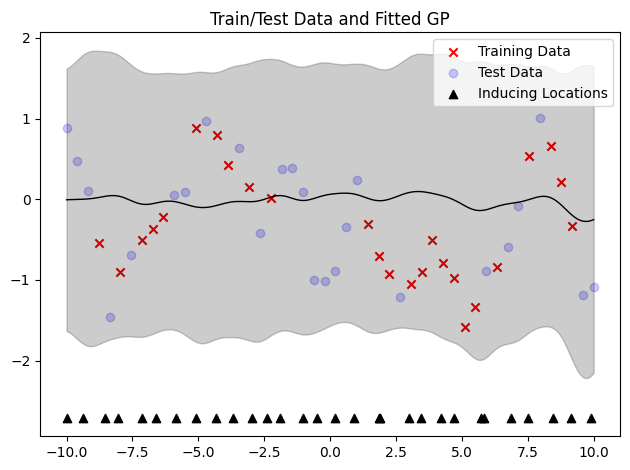

In [157]:
function_index = 12
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(function_index)
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{config["n_outputs"]}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input'], picture_save_path=picture_save_path) # NOTE: input is C not X

# Debugging

In [131]:
test_input = Tensor([-6.5])

input_K_f_u = my_model.covar_module_input(test_input, my_model.variational_strategy.inducing_points_input.data).to_dense().data
input_K_u_f_K_f_u = input_K_f_u.t() @ input_K_f_u

data_specific_background_information = {
        'm_plus': my_model.X.q_mu.data[90],
        'Sigma_plus': 1.0 * my_model.X.q_log_sigma.exp().square().data[0],
        'input_K_f_u': input_K_f_u, 
        'input_K_u_f_K_f_u': input_K_u_f_K_f_u,
        'expectation_K_uu': None
}

H_test = my_model.variational_strategy.inducing_points_latent.data[-1]

# print(H_test)
# print(data_specific_background_information['m_plus'])
H_concate = torch.concatenate((H_test, data_specific_background_information['m_plus'])).reshape(2,2)
print(H_concate)

tensor([[ 1.2369, -0.3837],
        [-0.8744,  1.1158]])


## Testing function G

In [132]:
def multivariate_gaussian_pdf(x, mu, cov):
        '''cov is a vector, representing all elements in the diagonal matrix'''
        # x = x.to(torch.double)
        # mu = mu.to(torch.double)
        # cov = cov.to(torch.double)

        k = mu.size(0)
        cov_det = cov.prod()
        cov_inv = torch.diag(1.0 / cov)
        norm_factor = torch.sqrt((2 * torch.pi) ** k * cov_det)

        x_mu = x - mu
        result = torch.exp(-0.5 * x_mu @ cov_inv @ x_mu.t()) / norm_factor
        return result.item()

def G(h:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):

        mu = data_specific_background_information['m_plus']
        cov_diag = data_specific_background_information['Sigma_plus'] + common_background_information['W']
        result = multivariate_gaussian_pdf(h, mu, cov_diag)
        return common_background_information['constant_c'] * result

In [133]:
# a = my_model.covar_module_latent.outputscale.data
# b = my_model.covar_module_latent.base_kernel.lengthscale.data[0]
# print(a)
# print(b)
# a * np.exp( -0.5 * ( ((H_concate[0][0] - H_concate[1][0]) / b[0])**2 + ((H_concate[1][0] - H_concate[1][0]) / b[0])**2 ) )

In [134]:
# Ground Truth

my_model.covar_module_latent(H_concate).to_dense().data

tensor([[8.4719e-01, 1.2907e-04],
        [1.2907e-04, 8.4719e-01]])

In [135]:
# to test
G(H_test)

tensor(0.0001)

In [136]:
Tensor([G(my_model.variational_strategy.inducing_points_latent.data[i]).item() for i in range(config['n_inducing_latent'])])

tensor([3.6383e-03, 7.4513e-03, 5.7119e-02, 1.2134e-02, 5.5787e-03, 4.7943e-05,
        2.9643e-01, 2.7031e-01, 1.0004e-01, 2.8716e-01, 2.7085e-03, 5.4258e-01,
        2.6272e-05, 4.6681e-04, 4.9462e-01, 1.0048e-04, 1.9835e-03, 6.0721e-01,
        1.1167e-01, 7.4552e-02, 4.5224e-02, 6.1597e-07, 1.2430e-06, 2.8809e-03,
        1.0139e-01, 4.1192e-04, 6.7494e-02, 1.3546e-05, 3.6136e-08, 1.3386e-04])

## Testing function R 

In [137]:
def R(h_1:Tensor, h_2:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
    mu_1 = h_2
    cov_diag_1 = 2 * common_background_information['W']
    mu_2 = (h_1 + h_2) / 2
    cov_diag_2 = 0.5 * common_background_information['W'] + data_specific_background_information['Sigma_plus']
    result1 = multivariate_gaussian_pdf(h_1, mu_1, cov_diag_1)
    result2 = multivariate_gaussian_pdf(data_specific_background_information['m_plus'], mu_2, cov_diag_2)
    return (common_background_information['constant_c'] ** 2 ) * result1 * result2

def R_(h_1:Tensor, h_2:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
    mu_1 = h_2
    cov_diag_1 = 2 * common_background_information['W']
    mu_2 = (h_1 + h_2) / 2
    cov_diag_2 = 0.5 * common_background_information['W']
    result1 = multivariate_gaussian_pdf(h_1, mu_1, cov_diag_1)
    result2 = multivariate_gaussian_pdf(data_specific_background_information['m_plus'], mu_2, cov_diag_2)
    return (common_background_information['constant_c'] ** 2 ) * result1 * result2
    

In [138]:
h1_test = my_model.variational_strategy.inducing_points_latent.data[14]
h2_test = my_model.variational_strategy.inducing_points_latent.data[3]

In [139]:
R(h1_test, h2_test)

tensor(0.0060)

In [140]:
R_(h1_test, h2_test)

tensor(0.0059)

## Testing expectation lambda

In [141]:
expectation_latent_K_f_u = Tensor([G(my_model.variational_strategy.inducing_points_latent.data[i]).item() for i in range(config['n_inducing_latent'])])
expectation_latent_K_u_f_K_f_u = Tensor([R(my_model.variational_strategy.inducing_points_latent.data[i], my_model.variational_strategy.inducing_points_latent.data[j]).item() \
                                        for j in range(config['n_inducing_latent']) for i in range(config['n_inducing_latent'])]).reshape(config['n_inducing_latent'], config['n_inducing_latent'])

data_specific_background_information['expectation_latent_K_f_u'] = expectation_latent_K_f_u
data_specific_background_information['expectation_latent_K_u_f_K_f_u'] = expectation_latent_K_u_f_K_f_u

def expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
    result_ = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_f_u'].reshape(1, -1), data_specific_background_information['input_K_f_u'].reshape(1, -1)).to_dense().data 
    result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u'].to(result_.dtype)
    return result_

# to test
expectation_lambda()

tensor([0.5702])

In [142]:
# Ground Truth
H_induc = my_model.variational_strategy.inducing_points_latent.data
H_concate = torch.concatenate((data_specific_background_information['m_plus'].reshape(1, 2), H_induc), axis=0)
K_H_f_u = my_model.covar_module_latent(H_concate).to_dense().data[0, 1:].reshape(1, -1)

intern_term = (KroneckerProductLinearOperator(K_H_f_u, data_specific_background_information['input_K_f_u']).to_dense().data).to(torch.double)
intern_term_2 = common_background_information['chol_K_uu_inv_t'].to(torch.double) @ common_background_information['m_u'].to(torch.double)
print(intern_term @ intern_term_2)

tensor([0.5729], dtype=torch.float64)


## Testing expectation lambda square

In [143]:
def expectation_lambda_square(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
    result_ = common_background_information['m_u']
    _result = result_ @ common_background_information['chol_K_uu_inv_t'].t().to(result_.dtype)
    interm_term = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data
    result_ = _result @ interm_term.to(result_.dtype) @ _result.t()
    # result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u']

    if data_specific_background_information['expectation_K_uu'] == None:
        data_specific_background_information['expectation_K_uu'] = interm_term
    return result_

# to test
print(expectation_lambda_square())

tensor(0.3263)


## Testing expectation gamma

In [144]:
# Ground Truth
pred_dist = my_model(data_specific_background_information['m_plus'].reshape(1, 2), test_input.reshape(1, 1))
print('pred mean: ', pred_dist.loc.detach())
print('pred cov: ', pred_dist.variance.detach())

pred mean:  tensor([0.5729], dtype=torch.float64)
pred cov:  tensor([0.1756], dtype=torch.float64)


In [145]:
def expectation_gamma(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
    result_ = common_background_information['var_H'] * common_background_information['var_X']

    if data_specific_background_information['expectation_K_uu'] == None:
        data_specific_background_information['expectation_K_uu'] = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], \
                                                                                                data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data

    return result_ + (common_background_information['A'] * data_specific_background_information['expectation_K_uu']).sum()

expectation_gamma()

tensor(0.1746, dtype=torch.float64)